## Batch Inference Version 2

In [1]:
from xgboost import (
    XGBClassifier, 
    plot_importance,
)
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

### Connecting to Hopsworks Feature Store

In [2]:
import hopsworks

project = hopsworks.login()

fs = project.get_feature_store()

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1133716
2024-10-25 08:35:52,917 WARNING: using legacy validation callback
Connected. Call `.close()` to terminate connection gracefully.


### Feature View Retrieval

In [3]:
import hsfs
connection = hsfs.connection()
fs = connection.get_feature_store(name='jworkspace_featurestore')

# Retrieve the churn_feature_view
feature_view = fs.get_feature_view(
        name = 'churn_feature_view',
        version = 2,
)

Connected. Call `.close()` to terminate connection gracefully.


### Model Registry

In [4]:
# Get the model registry
mr = project.get_model_registry()

Connected. Call `.close()` to terminate connection gracefully.


### Fetch and test the model

In [5]:
# Retrieve the model from the model registry
retrieved_model = mr.get_model(
    name="churnmodelv2",
    version=1,
)

# Download the saved model files to a local directory
saved_model_dir = retrieved_model.download()

In [6]:
# Initialize the model
model = XGBClassifier()

# Load the model from a saved JSON file
model.load_model(saved_model_dir + "/model_v2.json")
model

XGBClassifier(base_score='5.1609343E-1', booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None,
              feature_types=['int', 'int', 'int', 'int', 'int', 'int', 'int',
                             'int', 'int', 'int', 'int', 'int', 'int', 'int',
                             'int', 'int', 'int', 'int', 'int'],
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

### Use trained model to identify customers at risk of churn

In [7]:
def transform_preds(predictions):
    # Transform numeric predictions to human-readable labels
    return [
        'Churn'
        if pred == 1
        else 'Not Churn'
        for pred
        in predictions
    ]

In [12]:
# Initialize batch scoring with the correct training dataset version
feature_view.init_batch_scoring(training_dataset_version=6)

# Get the batch data
batch_data = feature_view.get_batch_data()

# Display the first three rows of the batch_data
batch_data.head(3)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (6.25s) 


,contract,tenure,paymentmethod,paperlessbilling,monthlycharges,totalcharges,gender,seniorcitizen,dependents,partner,...,deviceprotection,onlinebackup,onlinesecurity,internetservice,multiplelines,phoneservice,techsupport,streamingmovies,streamingtv,datetime
0,0,0.819444,0,0,0.711443,0.633835,0,1,0,0,...,0,0,0,0,0,0,0,0,0,2021-12-24 02:39:30.008520+00:00
1,0,0.013889,0,0,0.749254,0.010787,1,1,0,0,...,1,1,1,0,0,0,0,1,1,2020-06-14 23:38:56.268105+00:00
2,0,0.527778,1,0,0.632836,0.362262,1,0,1,0,...,1,0,1,0,0,0,0,0,0,2021-01-02 06:21:09.866515+00:00


Let's predict the all for all customer data and then visualize predictions.

In [13]:
# Check the feature names used during training
print(model.get_booster().feature_names)

['contract', 'tenure', 'paymentmethod', 'paperlessbilling', 'monthlycharges', 'totalcharges', 'gender', 'seniorcitizen', 'dependents', 'partner', 'deviceprotection', 'onlinebackup', 'onlinesecurity', 'internetservice', 'multiplelines', 'phoneservice', 'techsupport', 'streamingmovies', 'streamingtv']


In [16]:
# Drop the 'customerid' column from the batch data
batch_data.drop(['datetime'], axis=1, inplace=True)

# Use the retrieved XGBoost model to make predictions on the batch data
predictions = model.predict(batch_data)

# Transform numeric predictions to human-readable labels
predictions = transform_preds(predictions)

# Display the first five predictions
predictions[:5]

['Not Churn', 'Churn', 'Not Churn', 'Not Churn', 'Churn']

### Prediction Visualisation

In [17]:
import inspect 

# Recall that you applied transformation functions, such as min max scaler and laber encoder. 
# Now you want to transform them back to human readable format.
df_all = batch_data.copy()
td_transformation_functions = feature_view._batch_scoring_server._transformation_functions
for feature_name in td_transformation_functions:
    td_transformation_function = td_transformation_functions[feature_name]
    sig, foobar_locals = inspect.signature(td_transformation_function.transformation_fn), locals()
    param_dict = dict([(param.name, param.default) for param in sig.parameters.values() if param.default != inspect._empty])
    if td_transformation_function.name == "label_encoder":
        rev_dict = {v: k for k, v in param_dict["value_to_index"].items()}
        df_all[feature_name] = df_all[feature_name].map(lambda x: rev_dict[x])
    if td_transformation_function.name == "min_max_scaler":
        df_all[feature_name] = df_all[feature_name].map(lambda x: x*(param_dict["max_value"]-param_dict["min_value"])+param_dict["min_value"])

            
df_all = df_all
df_all['Churn'] = predictions
df_all.head()

,contract,tenure,paymentmethod,paperlessbilling,monthlycharges,totalcharges,gender,seniorcitizen,dependents,partner,deviceprotection,onlinebackup,onlinesecurity,internetservice,multiplelines,phoneservice,techsupport,streamingmovies,streamingtv,Churn
0,Month-to-month,59.0,Electronic check,Yes,89.75,5496.90,Female,1,No,No,Yes,Yes,Yes,Fiber optic,Yes,Yes,No,No,No,Not Churn
1,Month-to-month,1.0,Electronic check,Yes,93.55,93.55,Male,1,No,No,No,No,No,Fiber optic,Yes,Yes,No,Yes,Yes,Churn
2,Month-to-month,38.0,Mailed check,Yes,81.85,3141.70,Male,0,Yes,No,No,Yes,No,Fiber optic,Yes,Yes,No,No,No,Not Churn
3,Two year,64.0,Bank transfer (automatic),No,110.30,6997.30,Female,0,Yes,Yes,No,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Not Churn
4,Month-to-month,24.0,Bank transfer (automatic),Yes,49.55,1210.40,Male,0,No,No,No,No,Yes,DSL,No,Yes,No,No,No,Churn


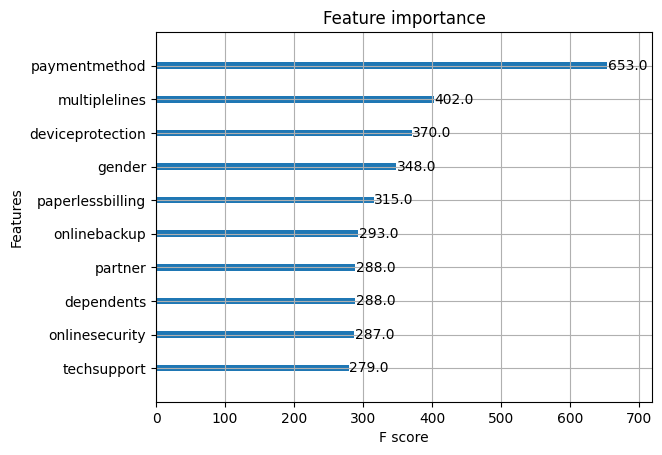

In [18]:
# Plot feature importance using XGBoost's plot_importance function
figure_imp = plot_importance(
    model,                    # The retrieved XGBoost model
    max_num_features=10,      # Maximum number of features to display
    importance_type='weight', # Type of importance to display ('weight' represents the number of times a feature appears in a tree across all trees)
)

# Show the plot
plt.show()

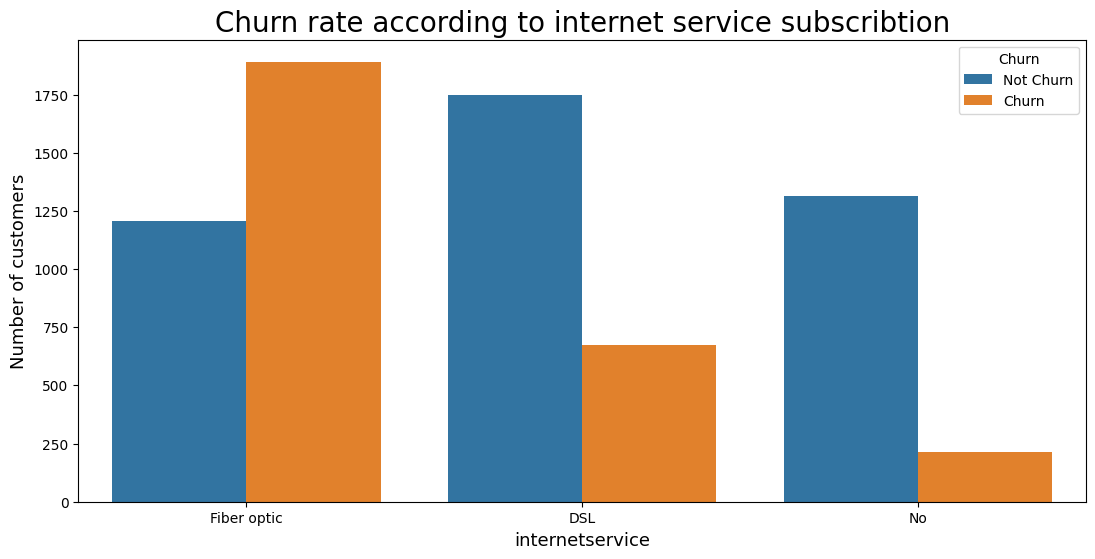

In [19]:
plt.figure(figsize = (13,6))

sns.countplot(
    data=df_all,
    x='internetservice',
    hue='Churn',
)

plt.title('Churn rate according to internet service subscribtion', fontsize=20)
plt.xlabel("internetservice", fontsize=13)
plt.ylabel('Number of customers', fontsize=13)

plt.show()

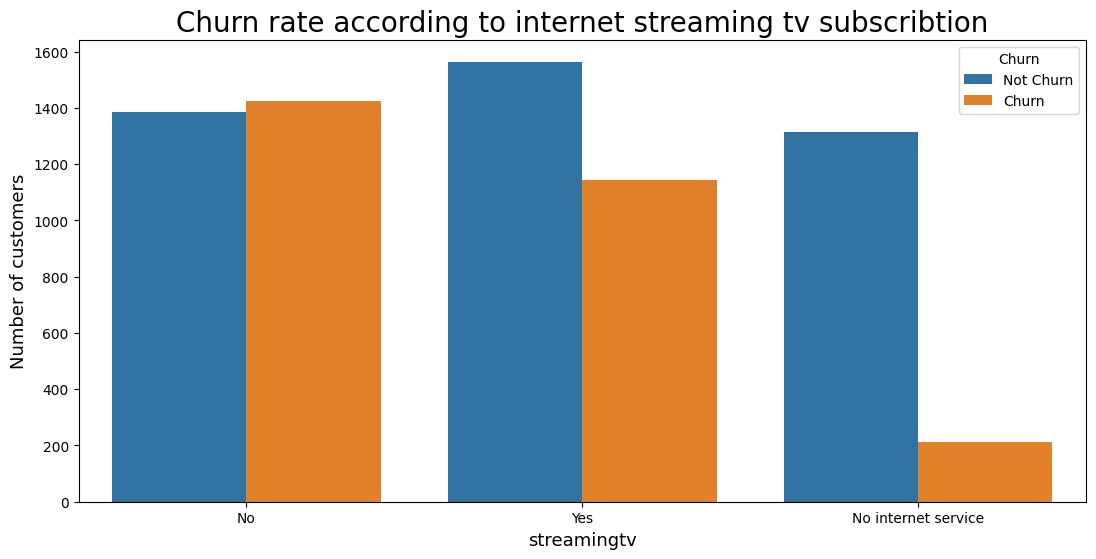

In [20]:
plt.figure(figsize = (13,6))

sns.countplot(
    data=df_all,
    x='streamingtv',
    hue='Churn',
)

plt.title('Churn rate according to internet streaming tv subscribtion', fontsize=20)
plt.xlabel("streamingtv", fontsize=13)
plt.ylabel('Number of customers', fontsize=13)

plt.show()

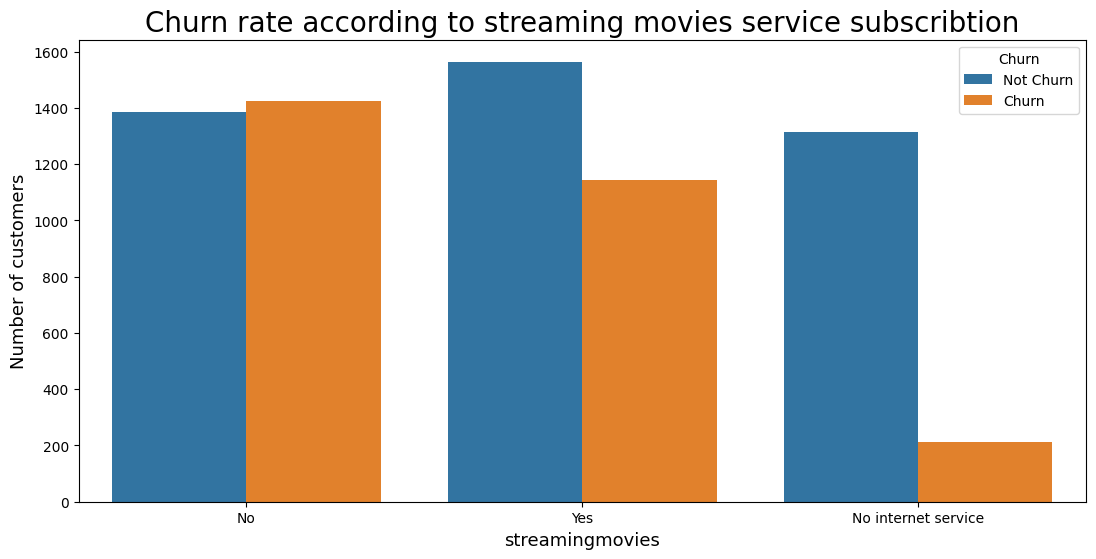

In [21]:
plt.figure(figsize = (13,6))

sns.countplot(
    data=df_all,
    x='streamingtv',
    hue='Churn',
)

plt.title('Churn rate according to streaming movies service subscribtion', fontsize=20)
plt.xlabel("streamingmovies", fontsize=13)
plt.ylabel('Number of customers', fontsize=13)

plt.show()

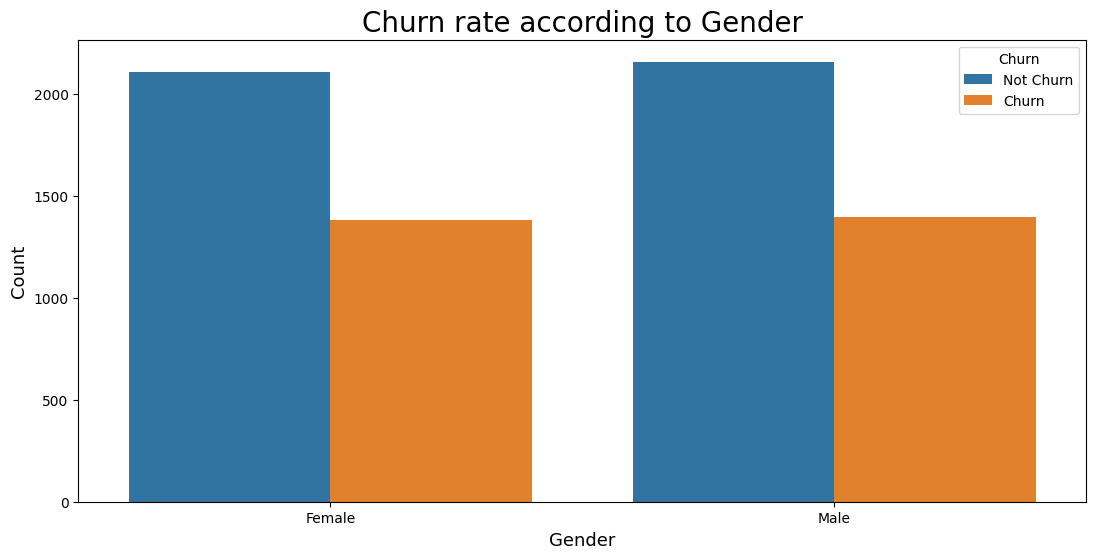

In [22]:
plt.figure(figsize = (13,6))

sns.countplot(
    data=df_all,
    x='gender',
    hue='Churn',
)

plt.title('Churn rate according to Gender', fontsize=20)
plt.xlabel("Gender", fontsize=13)
plt.ylabel('Count', fontsize=13)

plt.show()

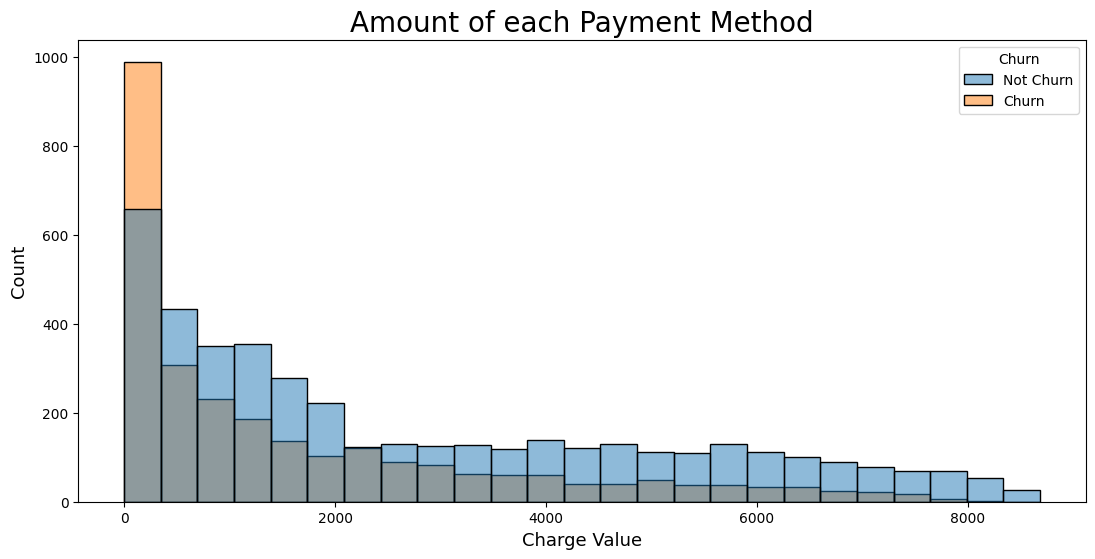

In [23]:
plt.figure(figsize = (13,6))

sns.histplot(
    data=df_all,
    x='totalcharges',
    hue='Churn',
)

plt.title('Amount of each Payment Method', fontsize=20)
plt.xlabel("Charge Value", fontsize=13)
plt.ylabel('Count', fontsize=13)

plt.show()

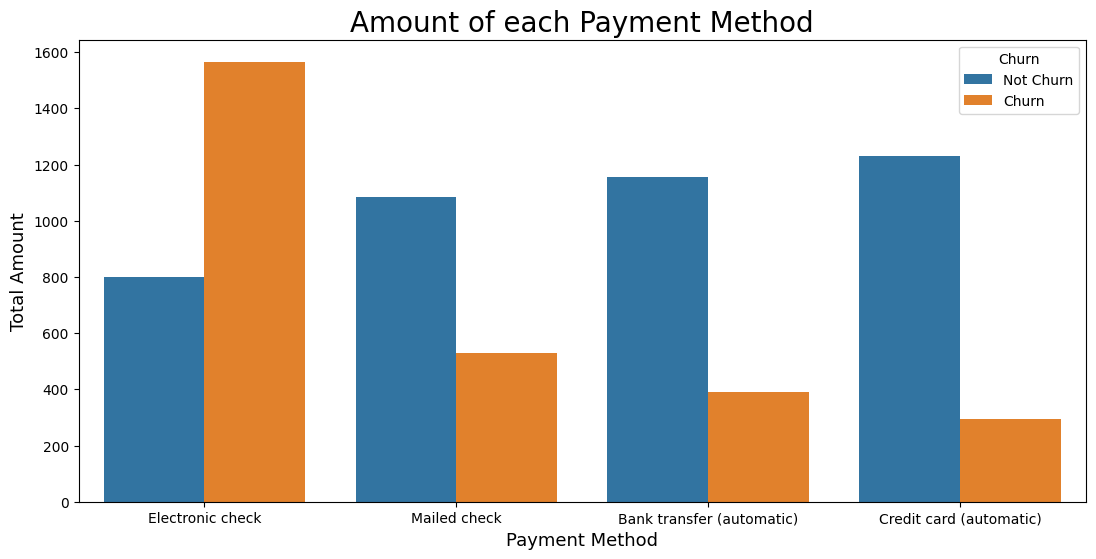

In [24]:
plt.figure(figsize = (13,6))

sns.countplot(
    data=df_all,
    x='paymentmethod',
    hue='Churn',
)

plt.title('Amount of each Payment Method', fontsize=20)
plt.xlabel("Payment Method", fontsize=13)
plt.ylabel('Total Amount', fontsize=13)

plt.show()

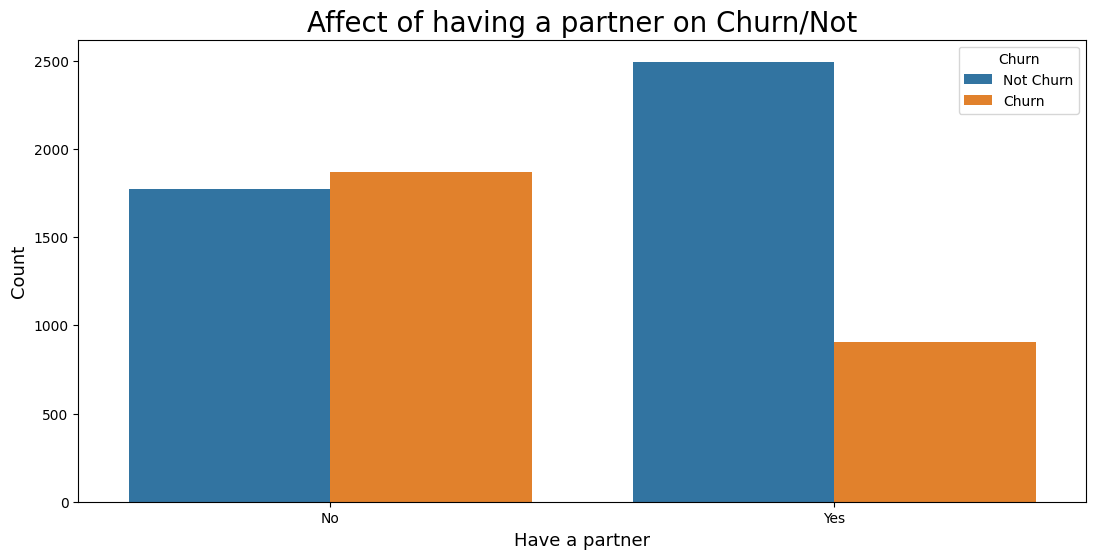

In [25]:
plt.figure(figsize = (13,6))

sns.countplot(
    data=df_all,
    x='partner',
    hue='Churn',
)

plt.title('Affect of having a partner on Churn/Not', fontsize=20)
plt.xlabel("Have a partner", fontsize=13)
plt.ylabel('Count', fontsize=13)

plt.show()